In [39]:
%matplotlib inline
%config IPCompleter.greedy=True

import os
import sys

#Import packages we need
import numpy as np
from netCDF4 import Dataset
import datetime
from IPython.display import display
import matplotlib
from matplotlib import pyplot as plt
import importlib
from datetime import timedelta

#Set large figure sizes
#plt.rcParams["animation.html"] = "jshtml" #Javascript 
plt.rcParams["animation.html"] = "html5" #mp4
plt.rcParams["figure.dpi"] = 100.0 #highres movies/plots

plt.rcParams["animation.writer"] = 'ffmpeg' 
plt.rcParams["animation.codec"] = 'h264' 

plt.rcParams["text.usetex"] = True
plt.rcParams["font.family"] = 'serif'

#Path
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '../../')))

In [40]:
#For GPUOcean
from SWESimulators import CDKLM16, Common, IPythonMagic, NetCDFInitialization
from SWESimulators import GPUDrifterCollection, Observation
from SWESimulators import DataAssimilationUtils as dautils
from demos.realisticSimulations import norkyst_plotting

#For Opendrift
from opendrift.readers import reader_netCDF_CF_generic
from opendrift.models.oceandrift import OceanDrift

#For OceanParcels
from parcels import FieldSet, ParticleSet, Variable, JITParticle, AdvectionRK4, plotTrajectoriesFile, Field

In [41]:
%cuda_context_handler gpu_ctx

In [42]:
def simulate_parcels(source_url, output_filename, lat, lon, wind_drift_percentage, velocity_average, hours=23):
    filenames = {'U' : source_url, 'V': source_url}
    dimensions = {'lat': 'lat','lon': 'lon','time': 'time'}

    if velocity_average: 
        variables = {'U': 'ubar', 'V': 'vbar'}
    else:
        variables = {'U': 'u', 'V': 'v'}

    fieldset = FieldSet.from_netcdf(filenames, variables, dimensions, interp_method = 'cgrid_velocity')
    
    if wind_drift_percentage:
        Uwind = Field.from_netcdf(source_url, ('U', 'Uwind'), dimensions, field_chunksize='auto', interp_method = 'cgrid_velocity')
        Vwind = Field.from_netcdf(source_url, ('V', 'Vwind'), dimensions, field_chunksize='auto', interp_method = 'cgrid_velocity')
        Uwind.set_scaling_factor(wind_drift_percentage)
        Vwind.set_scaling_factor(wind_drift_percentage)
        fieldset = FieldSet(U = fieldset.U+ Uwind,V = fieldset.V+ Vwind)

    pset = ParticleSet.from_list(fieldset = fieldset, pclass = JITParticle, lon=lon, lat=lat)
    output_file = pset.ParticleFile(name = output_filename, outputdt = timedelta(minutes=15))

    pset.execute(AdvectionRK4, runtime = timedelta(hours = hours), dt = timedelta(minutes=5), output_file = output_file)

    output_file.export()

In [53]:
def simulate_opendrift(source_url, lat, lon, wind_drift_percentage, velocity_average, hours=23):
    reader_norkyst = reader_netCDF_CF_generic.Reader(source_url)
    o = OceanDrift(loglevel=20)
    
    if velocity_average:
        reader_norkyst.variable_mapping['x_sea_water_velocity'] = 'ubar'
        reader_norkyst.variable_mapping['y_sea_water_velocity'] = 'vbar'
    
    o.add_reader(reader_norkyst, variables=['x_sea_water_velocity', 'y_sea_water_velocity', 'x_wind', 'y_wind'])
    #readers = [None]*len(source_url)
    #for n in range(len(source_url)):
    #    readers[n]=reader_netCDF_CF_generic.Reader(source_url[n])
    #    o.add_reader(readers[n], variables=['x_sea_water_velocity', 'y_sea_water_velocity', 'x_wind', 'y_wind'])
        
    o.seed_elements(lon= lon, lat=lat, radius=1, number=1, time=reader_norkyst.start_time, wind_drift_factor = wind_drift_percentage)
    
    o.set_config('drift:scheme', 'runge-kutta4')
    
    o.run(duration = timedelta(hours=hours), time_step = 300, time_step_output = 900)
    
    return o

In [44]:
def initlonlat2initgpuocean(opendrift_obj, X_norkyst, Y_norkyst, lon, lat, num_cells_x, num_cells_y, res = 800):
    #Finding tentative x,y(not for a specific domain)
    x, y = opendrift_obj.lonlat2xy(lon,lat)

    #Given x,y, num_cells_x, num_cells_y and resolution: specify domain in gpuocean
    x0, x1 = x//res - num_cells_x, x//res + num_cells_x 
    y0, y1 = y//res - num_cells_y, y//res + num_cells_y

    #Find new x,y in gpuocean coordinates for initial position
    xinit = x - X[int(x0) + 2]
    yinit = y- Y[int(y0) + 2]
    
    return xinit, yinit, int(x0), int(x1), int(y0), int(y1)

In [45]:
#Motsatt vei?
def gpuocean2lonlat(opendrift_obj, X_norkyst, Y_norkyst, x, y, x0, y0):
    x = x + X_norkyst[x0+2]
    y = y + Y_norkyst[y0+2]
    
    lon, lat = opendrift_obj.xy2lonlat(x,y)

    return lon, lat

In [46]:
def opendriftObj2gpuoceanObs(opendrift_obj,X_norkyst, Y_norkyst, x0, x1,y0,y1, res = 800,  land_mask = None):
    t = opendrift_obj.get_time_array()[1]
    for i in range(len(t)):
        t[i] = t[i].total_seconds()
    t = np.array(t)

    lon, lat = opendrift_obj.get_lonlats()
    x,y = opendrift_obj.lonlat2xy(lon,lat)
    
    x = x - X_norkyst[x0 +2] # in m
    y = y- Y_norkyst[y0 +2] # in m
    
    #TODO: Remove drifters ouside the domain

    nx = (x1-x0-4) #num_cells
    ny = (y1-y0-4) #num_cells
    
    obs = Observation.Observation(domain_size_x = nx*res,
                                    domain_size_y = ny*res,
                                    nx=x1-x0-4, ny=y1-y0-4, land_mask = land_mask)
    
    obs.add_observations_from_arrays(t,x,y) #x,y i m fra origin i gpuocean ?
    
    return obs

In [47]:
def parcelsFile2gpuoceanObs(filename, opendrift_obj, X_norkyst, Y_norkyst, x0, x1, y0,y1, res = 800, land_mask = None):
    pfile = Dataset(filename)
    t = pfile.variables['time'][0,:]
    lon = np.ma.filled(pfile.variables['lon'], np.nan)
    lat = np.ma.filled(pfile.variables['lat'], np.nan)
    pfile.close()

    x,y = opendrift_obj.lonlat2xy(lon,lat)
    
    x = x - X_norkyst[x0 +2] # in m
    y = y- Y_norkyst[y0 +2] # in m
    
    #TODO: Remove drifters ouside the domain

    nx = (x1-x0-4) #num_cells
    ny = (y1-y0-4) #num_cells
    
    obs = Observation.Observation(domain_size_x = nx*res,
                                    domain_size_y = ny*res,
                                    nx=x1-x0-4, ny=y1-y0-4, land_mask = land_mask)
    
    obs.add_observations_from_arrays(t,x,y) #x,y i m fra origin i gpuocean ?
    
    return obs

In [70]:
#Simulating gpu-ocean run OBS: only trajectory output
sim_args = {
    "gpu_ctx": gpu_ctx,
    "dt": 0.0,
    "rk_order": 2,
    "desingularization_eps": 1.0
     }

outfolder = 'deterministic_forecast_test'

def simulate_gpuocean_deterministic(source_url, domain, initx, inity, erode_land, sim_args,rescale=0,observation_type = dautils.ObservationType.UnderlyingFlow, outfolder = None, start_forecast_hours = 0, forecast_duration = 23 ):
    
    end_forecast_hours = start_forecast_hours + forecast_duration
    
    #Create simulator
    data_args = NetCDFInitialization.getInitialConditions(source_url, domain[0], domain[1], domain[2],domain[3] , 
                     timestep_indices = None, erode_land = erode_land, download_data = False)
    
    if rescale:
        print('hei')
        data_args = NetCDFInitialization.rescaleInitialConditions(data_args, scale=rescale)

    importlib.reload(CDKLM16)
    sim = CDKLM16.CDKLM16(**sim_args, **NetCDFInitialization.removeMetadata(data_args))
    
    #Forecast
    observation_args = {'observation_type': observation_type,
                    'nx': sim.nx, 'ny': sim.ny,
                    'domain_size_x': sim.nx*sim.dx,
                    'domain_size_y': sim.ny*sim.dy,
                    'land_mask': sim.getLandMask()
                   }

    trajectory_forecast = Observation.Observation(**observation_args)

    if outfolder is not None:
        out_folder = os.path.abspath(outfolder)
        os.makedirs(out_folder, exist_ok=True)
        trajectory_forecast_filename = 'trajectory_forecast_'+str(start_forecast_hours)+'_to_'+str(end_forecast_hours)+'.pickle'
        trajectory_forecast_path = os.path.join(out_folder, trajectory_forecast_filename)
    
    #Drifters
    #Assumes initx, inity same format/shape
    if type(initx) is not list:
        initx = [initx]
        inity = [inity]
    
    num_drifters = len(initx)
    
    drifters = GPUDrifterCollection.GPUDrifterCollection(gpu_ctx, num_drifters, 
                                                     boundaryConditions = sim.boundary_conditions,
                                                     domain_size_x = trajectory_forecast.domain_size_x,
                                                     domain_size_y = trajectory_forecast.domain_size_y,
                                                     gpu_stream = sim.gpu_stream)
    
    drifter_pos_init = np.array([initx, inity]).T
    
    #Run simulation
    num_total_hours = end_forecast_hours
    
    five_mins_in_an_hour = 12
    sub_dt = 5*60 # five minutes
    
    progress = Common.ProgressPrinter(5)
    pp = display(progress.getPrintString(0), display_id=True)

    for hour in range(num_total_hours):
        
        if hour == start_forecast_hours:
            # Attach drifters
            drifters.setDrifterPositions(drifter_pos_init)
            sim.attachDrifters(drifters)
            trajectory_forecast.add_observation_from_sim(sim)
        
        for mins in range(five_mins_in_an_hour):
            t = sim.step(sub_dt)
            if hour >= start_forecast_hours:
                trajectory_forecast.add_observation_from_sim(sim)
        
        pp.update(progress.getPrintString(hour/(end_forecast_hours-1)))
    
    if outfolder is not None:
        trajectory_forecast.to_pickle(trajectory_forecast_path)
    
    return trajectory_forecast


In [54]:
source_url =  ['/home/johanna/gpu-ocean/gpu_ocean/demos/MPI_SIR/netcdf_cache/NorKyst-800m_ZDEPTHS_his.an.2019071600.nc', 
               '/home/johanna/gpu-ocean/gpu_ocean/demos/MPI_SIR/netcdf_cache/NorKyst-800m_ZDEPTHS_his.an.2019071700.nc', 
               '/home/johanna/gpu-ocean/gpu_ocean/demos/MPI_SIR/netcdf_cache/NorKyst-800m_ZDEPTHS_his.an.2019071800.nc'
              ]
purl = '/home/johanna/gpu-ocean/gpu_ocean/demos/MPI_SIR/netcdf_cache/*'
url = '/home/johanna/gpu-ocean/gpu_ocean/demos/MPI_SIR/netcdf_cache/NorKyst-800m_ZDEPTHS_his.an.2019071600.nc'
#Save X, Y(dimensions) from netcdf file from norkyst800
ncfile = Dataset(url)
X = ncfile.variables['X'][:]
Y = ncfile.variables['Y'][:]
ncfile.close()

#Create OpendriftObject with norkys data to access coordinate-change lonlat2xy
reader_norkyst = reader_netCDF_CF_generic.Reader(url)
o = OceanDrift(loglevel=50)
o.add_reader(reader_norkyst, variables=['x_sea_water_velocity', 'y_sea_water_velocity'])

lon, lat = 14.1,69.4
hours = 70

14:40:51 INFO: Opening dataset: /home/johanna/gpu-ocean/gpu_ocean/demos/MPI_SIR/netcdf_cache/NorKyst-800m_ZDEPTHS_his.an.2019071600.nc
14:40:51 INFO: Opening file with Dataset


In [55]:

o1 = simulate_opendrift(source_url, lat, lon, 0.0, True, hours) #no wind, average velocity


will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  self.Dataset = xr.open_mfdataset(filename)

to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternatively, to continue concatenating based
on the order the datasets are supplied in future, please use the new
`combine_nested` function (or the `combine='nested'` option to
open_mfdataset).
  from_openmfds=True,

14:40:53 INFO: OpenDriftSimulation initialised (version 1.2.3)
14:40:53 INFO: Config validation OK
14:40:53 INFO: Adding a dynamical landmask with max. priority based on assumed maximum speed of 1 m/s. Adding a customised landmask may be faster...
14:40:56 INFO: Using existing reader for land_binary_mask
14:40:56 INFO: All points are in ocean
14:40:56 INFO: 2019-07-16 00:00:00 - step 1 of

14:43:44 INFO: 2019-07-16 06:30:00 - step 79 of 840 - 1 active elements (0 deactivated)
14:43:44 INFO: 2019-07-16 06:35:00 - step 80 of 840 - 1 active elements (0 deactivated)
14:43:44 INFO: 2019-07-16 06:40:00 - step 81 of 840 - 1 active elements (0 deactivated)
14:43:44 INFO: 2019-07-16 06:45:00 - step 82 of 840 - 1 active elements (0 deactivated)
14:43:44 INFO: 2019-07-16 06:50:00 - step 83 of 840 - 1 active elements (0 deactivated)
14:43:44 INFO: 2019-07-16 06:55:00 - step 84 of 840 - 1 active elements (0 deactivated)
14:43:44 INFO: 2019-07-16 07:00:00 - step 85 of 840 - 1 active elements (0 deactivated)
14:44:03 INFO: 2019-07-16 07:05:00 - step 86 of 840 - 1 active elements (0 deactivated)
14:44:03 INFO: 2019-07-16 07:10:00 - step 87 of 840 - 1 active elements (0 deactivated)
14:44:03 INFO: 2019-07-16 07:15:00 - step 88 of 840 - 1 active elements (0 deactivated)
14:44:03 INFO: 2019-07-16 07:20:00 - step 89 of 840 - 1 active elements (0 deactivated)
14:44:03 INFO: 2019-07-16 07:25:

14:46:22 INFO: 2019-07-16 14:15:00 - step 172 of 840 - 1 active elements (0 deactivated)
14:46:22 INFO: 2019-07-16 14:20:00 - step 173 of 840 - 1 active elements (0 deactivated)
14:46:22 INFO: 2019-07-16 14:25:00 - step 174 of 840 - 1 active elements (0 deactivated)
14:46:22 INFO: 2019-07-16 14:30:00 - step 175 of 840 - 1 active elements (0 deactivated)
14:46:22 INFO: 2019-07-16 14:35:00 - step 176 of 840 - 1 active elements (0 deactivated)
14:46:22 INFO: 2019-07-16 14:40:00 - step 177 of 840 - 1 active elements (0 deactivated)
14:46:22 INFO: 2019-07-16 14:45:00 - step 178 of 840 - 1 active elements (0 deactivated)
14:46:22 INFO: 2019-07-16 14:50:00 - step 179 of 840 - 1 active elements (0 deactivated)
14:46:22 INFO: 2019-07-16 14:55:00 - step 180 of 840 - 1 active elements (0 deactivated)
14:46:23 INFO: 2019-07-16 15:00:00 - step 181 of 840 - 1 active elements (0 deactivated)
14:46:45 INFO: 2019-07-16 15:05:00 - step 182 of 840 - 1 active elements (0 deactivated)
14:46:45 INFO: 2019-0

14:48:55 INFO: 2019-07-16 22:00:00 - step 265 of 840 - 1 active elements (0 deactivated)
14:49:16 INFO: 2019-07-16 22:05:00 - step 266 of 840 - 1 active elements (0 deactivated)
14:49:16 INFO: 2019-07-16 22:10:00 - step 267 of 840 - 1 active elements (0 deactivated)
14:49:16 INFO: 2019-07-16 22:15:00 - step 268 of 840 - 1 active elements (0 deactivated)
14:49:16 INFO: 2019-07-16 22:20:00 - step 269 of 840 - 1 active elements (0 deactivated)
14:49:16 INFO: 2019-07-16 22:25:00 - step 270 of 840 - 1 active elements (0 deactivated)
14:49:16 INFO: 2019-07-16 22:30:00 - step 271 of 840 - 1 active elements (0 deactivated)
14:49:16 INFO: 2019-07-16 22:35:00 - step 272 of 840 - 1 active elements (0 deactivated)
14:49:16 INFO: 2019-07-16 22:40:00 - step 273 of 840 - 1 active elements (0 deactivated)
14:49:16 INFO: 2019-07-16 22:45:00 - step 274 of 840 - 1 active elements (0 deactivated)
14:49:16 INFO: 2019-07-16 22:50:00 - step 275 of 840 - 1 active elements (0 deactivated)
14:49:16 INFO: 2019-0

14:52:05 INFO: 2019-07-17 05:45:00 - step 358 of 840 - 1 active elements (0 deactivated)
14:52:05 INFO: 2019-07-17 05:50:00 - step 359 of 840 - 1 active elements (0 deactivated)
14:52:05 INFO: 2019-07-17 05:55:00 - step 360 of 840 - 1 active elements (0 deactivated)
14:52:05 INFO: 2019-07-17 06:00:00 - step 361 of 840 - 1 active elements (0 deactivated)
14:52:30 INFO: 2019-07-17 06:05:00 - step 362 of 840 - 1 active elements (0 deactivated)
14:52:30 INFO: 2019-07-17 06:10:00 - step 363 of 840 - 1 active elements (0 deactivated)
14:52:30 INFO: 2019-07-17 06:15:00 - step 364 of 840 - 1 active elements (0 deactivated)
14:52:30 INFO: 2019-07-17 06:20:00 - step 365 of 840 - 1 active elements (0 deactivated)
14:52:30 INFO: 2019-07-17 06:25:00 - step 366 of 840 - 1 active elements (0 deactivated)
14:52:30 INFO: 2019-07-17 06:30:00 - step 367 of 840 - 1 active elements (0 deactivated)
14:52:30 INFO: 2019-07-17 06:35:00 - step 368 of 840 - 1 active elements (0 deactivated)
14:52:30 INFO: 2019-0

14:55:28 INFO: 2019-07-17 13:30:00 - step 451 of 840 - 1 active elements (0 deactivated)
14:55:28 INFO: 2019-07-17 13:35:00 - step 452 of 840 - 1 active elements (0 deactivated)
14:55:28 INFO: 2019-07-17 13:40:00 - step 453 of 840 - 1 active elements (0 deactivated)
14:55:28 INFO: 2019-07-17 13:45:00 - step 454 of 840 - 1 active elements (0 deactivated)
14:55:28 INFO: 2019-07-17 13:50:00 - step 455 of 840 - 1 active elements (0 deactivated)
14:55:28 INFO: 2019-07-17 13:55:00 - step 456 of 840 - 1 active elements (0 deactivated)
14:55:28 INFO: 2019-07-17 14:00:00 - step 457 of 840 - 1 active elements (0 deactivated)
14:55:54 INFO: 2019-07-17 14:05:00 - step 458 of 840 - 1 active elements (0 deactivated)
14:55:54 INFO: 2019-07-17 14:10:00 - step 459 of 840 - 1 active elements (0 deactivated)
14:55:54 INFO: 2019-07-17 14:15:00 - step 460 of 840 - 1 active elements (0 deactivated)
14:55:54 INFO: 2019-07-17 14:20:00 - step 461 of 840 - 1 active elements (0 deactivated)
14:55:54 INFO: 2019-0

14:58:59 INFO: 2019-07-17 21:15:00 - step 544 of 840 - 1 active elements (0 deactivated)
14:58:59 INFO: 2019-07-17 21:20:00 - step 545 of 840 - 1 active elements (0 deactivated)
14:58:59 INFO: 2019-07-17 21:25:00 - step 546 of 840 - 1 active elements (0 deactivated)
14:58:59 INFO: 2019-07-17 21:30:00 - step 547 of 840 - 1 active elements (0 deactivated)
14:58:59 INFO: 2019-07-17 21:35:00 - step 548 of 840 - 1 active elements (0 deactivated)
14:58:59 INFO: 2019-07-17 21:40:00 - step 549 of 840 - 1 active elements (0 deactivated)
14:58:59 INFO: 2019-07-17 21:45:00 - step 550 of 840 - 1 active elements (0 deactivated)
14:58:59 INFO: 2019-07-17 21:50:00 - step 551 of 840 - 1 active elements (0 deactivated)
14:58:59 INFO: 2019-07-17 21:55:00 - step 552 of 840 - 1 active elements (0 deactivated)
14:58:59 INFO: 2019-07-17 22:00:00 - step 553 of 840 - 1 active elements (0 deactivated)
14:59:25 INFO: 2019-07-17 22:05:00 - step 554 of 840 - 1 active elements (0 deactivated)
14:59:25 INFO: 2019-0

15:01:56 INFO: 2019-07-18 05:00:00 - step 637 of 840 - 1 active elements (0 deactivated)
15:02:22 INFO: 2019-07-18 05:05:00 - step 638 of 840 - 1 active elements (0 deactivated)
15:02:22 INFO: 2019-07-18 05:10:00 - step 639 of 840 - 1 active elements (0 deactivated)
15:02:22 INFO: 2019-07-18 05:15:00 - step 640 of 840 - 1 active elements (0 deactivated)
15:02:22 INFO: 2019-07-18 05:20:00 - step 641 of 840 - 1 active elements (0 deactivated)
15:02:22 INFO: 2019-07-18 05:25:00 - step 642 of 840 - 1 active elements (0 deactivated)
15:02:22 INFO: 2019-07-18 05:30:00 - step 643 of 840 - 1 active elements (0 deactivated)
15:02:22 INFO: 2019-07-18 05:35:00 - step 644 of 840 - 1 active elements (0 deactivated)
15:02:22 INFO: 2019-07-18 05:40:00 - step 645 of 840 - 1 active elements (0 deactivated)
15:02:22 INFO: 2019-07-18 05:45:00 - step 646 of 840 - 1 active elements (0 deactivated)
15:02:22 INFO: 2019-07-18 05:50:00 - step 647 of 840 - 1 active elements (0 deactivated)
15:02:22 INFO: 2019-0

15:05:25 INFO: 2019-07-18 12:45:00 - step 730 of 840 - 1 active elements (0 deactivated)
15:05:25 INFO: 2019-07-18 12:50:00 - step 731 of 840 - 1 active elements (0 deactivated)
15:05:25 INFO: 2019-07-18 12:55:00 - step 732 of 840 - 1 active elements (0 deactivated)
15:05:25 INFO: 2019-07-18 13:00:00 - step 733 of 840 - 1 active elements (0 deactivated)
15:05:52 INFO: 2019-07-18 13:05:00 - step 734 of 840 - 1 active elements (0 deactivated)
15:05:52 INFO: 2019-07-18 13:10:00 - step 735 of 840 - 1 active elements (0 deactivated)
15:05:52 INFO: 2019-07-18 13:15:00 - step 736 of 840 - 1 active elements (0 deactivated)
15:05:52 INFO: 2019-07-18 13:20:00 - step 737 of 840 - 1 active elements (0 deactivated)
15:05:52 INFO: 2019-07-18 13:25:00 - step 738 of 840 - 1 active elements (0 deactivated)
15:05:52 INFO: 2019-07-18 13:30:00 - step 739 of 840 - 1 active elements (0 deactivated)
15:05:52 INFO: 2019-07-18 13:35:00 - step 740 of 840 - 1 active elements (0 deactivated)
15:05:52 INFO: 2019-0

15:08:50 INFO: 2019-07-18 20:30:00 - step 823 of 840 - 1 active elements (0 deactivated)
15:08:50 INFO: 2019-07-18 20:35:00 - step 824 of 840 - 1 active elements (0 deactivated)
15:08:50 INFO: 2019-07-18 20:40:00 - step 825 of 840 - 1 active elements (0 deactivated)
15:08:50 INFO: 2019-07-18 20:45:00 - step 826 of 840 - 1 active elements (0 deactivated)
15:08:50 INFO: 2019-07-18 20:50:00 - step 827 of 840 - 1 active elements (0 deactivated)
15:08:50 INFO: 2019-07-18 20:55:00 - step 828 of 840 - 1 active elements (0 deactivated)
15:08:50 INFO: 2019-07-18 21:00:00 - step 829 of 840 - 1 active elements (0 deactivated)
15:09:12 INFO: 2019-07-18 21:05:00 - step 830 of 840 - 1 active elements (0 deactivated)
15:09:12 INFO: 2019-07-18 21:10:00 - step 831 of 840 - 1 active elements (0 deactivated)
15:09:12 INFO: 2019-07-18 21:15:00 - step 832 of 840 - 1 active elements (0 deactivated)
15:09:12 INFO: 2019-07-18 21:20:00 - step 833 of 840 - 1 active elements (0 deactivated)
15:09:12 INFO: 2019-0

In [56]:
initx, inity, x0,x1, y0,y1 = initlonlat2initgpuocean(o, X, Y, lon, lat, 50,50)
o1obs = opendriftObj2gpuoceanObs(o1, X, Y, x0, x1,y0,y1)

In [59]:
domain = [x0,x1,y0,y1]
gpuobs = simulate_gpuocean_deterministic(source_url, domain, initx, inity, erode_land = 1, sim_args = sim_args, outfolder = None, forecast_duration = hours )

'0% [##############################] 100%. Total: 9m 10s, elapsed: 9m 10s, remaining: 0s'

In [60]:
simulate_parcels(purl, 'parcels_ex.nc', lat,lon,0.0,True,hours) #no wind, average velocity

INFO: Compiled JITParticleAdvectionRK4 ==> /tmp/parcels-1001/69eb6760f291215e3d356b6645af2cc0_0.so
INFO:parcels.tools.loggers:Compiled JITParticleAdvectionRK4 ==> /tmp/parcels-1001/69eb6760f291215e3d356b6645af2cc0_0.so
INFO: Temporary output files are stored in out-VBSHRJZY.
INFO:parcels.tools.loggers:Temporary output files are stored in out-VBSHRJZY.
INFO: You can use "parcels_convert_npydir_to_netcdf out-VBSHRJZY" to convert these to a NetCDF file during the run.
INFO:parcels.tools.loggers:You can use "parcels_convert_npydir_to_netcdf out-VBSHRJZY" to convert these to a NetCDF file during the run.
100% (252000.0 of 252000.0) |############| Elapsed Time: 0:00:26 Time:  0:00:26


In [61]:
pobs = parcelsFile2gpuoceanObs('parcels_ex.nc', o, X, Y, x0, x1, y0,y1)

In [71]:
gpuobs2 = simulate_gpuocean_deterministic(source_url, domain, initx, inity,rescale = 2, erode_land = 1, sim_args = sim_args, outfolder = None, forecast_duration = 23 )

'0% [##############################] 100%. Total: 6m 2s, elapsed: 6m 2s, remaining: 0s'

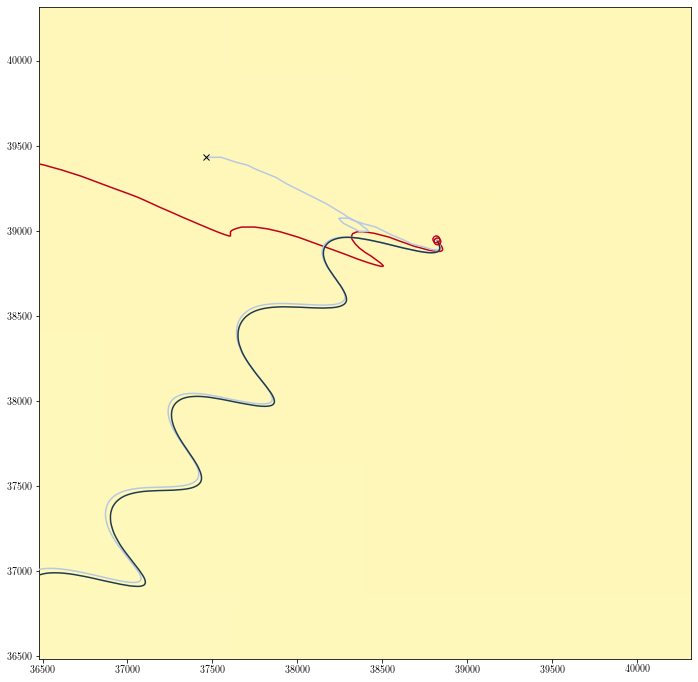

In [78]:
%matplotlib inline
#colors= ['xkcd:scarlet', 'xkcd:light blue grey', 'xkcd:dark blue grey']
ax = createForecastCanvas(gpuobs,background = True, url = url, domain = domain, zoom = 1/20)
plotAllDrifters(gpuobs, ax= ax, end = hours, color_id = 0)
plotAllDrifters(gpuobs2, ax= ax, end = 23, color_id = 1) #Hmm.....strange, må teste flere eksempler
plotAllDrifters(pobs, ax = ax, end = hours, color_id = 1)
plotAllDrifters(o1obs, ax=ax, end = hours, color_id = 2)
#REMARK: Different landmask here and in Opendrift. Opendrift is actually stranded.

In [ ]:
o1.plot(fast = True)

In [ ]:
xx, yy = o1.lonlat2xy(4.3, 61.5)
print(xx- X[x0+2], initx)
print(yy- Y[y0+2], inity)

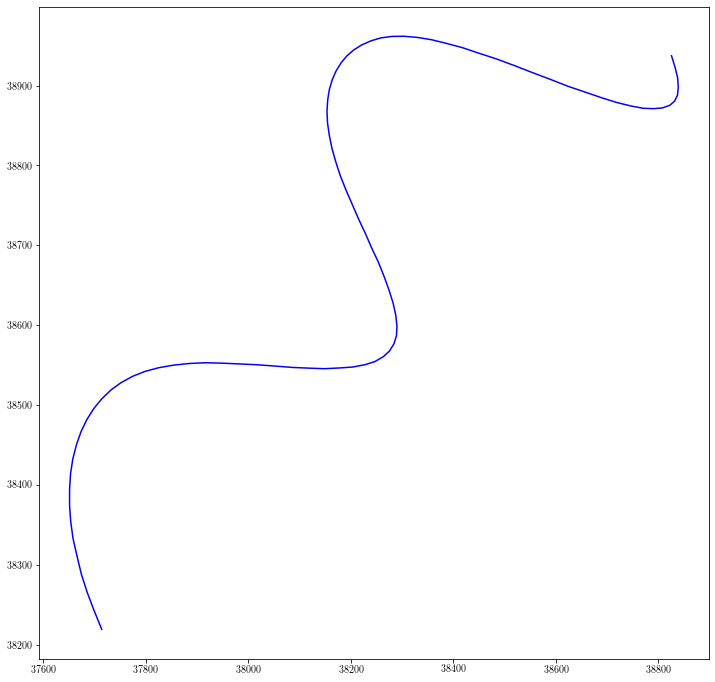

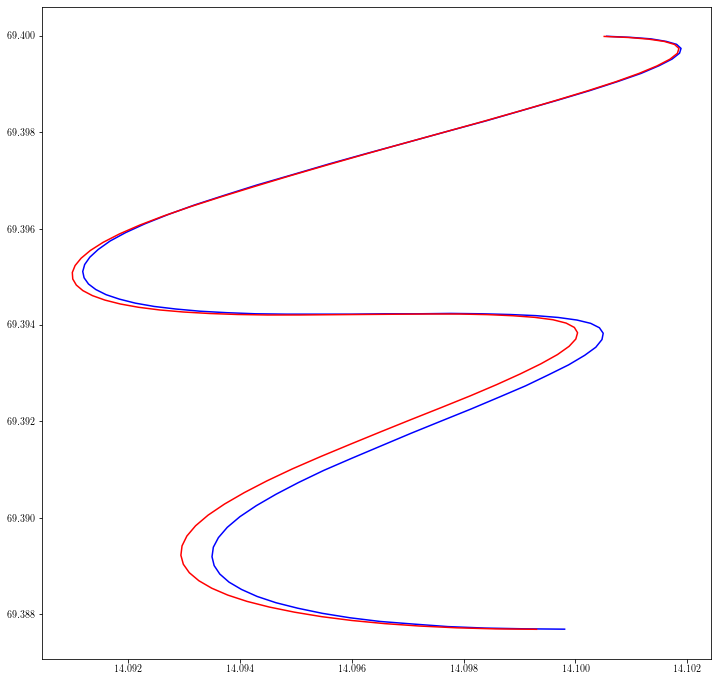

In [58]:
%matplotlib inline
#ptraj = pobs.get_drifter_path(0,0,23*3600, in_km = False)
#xp = ptraj[0].T[0]
#yp = ptraj[0].T[1]
traj = o1obs.get_drifter_path(0,0,23*3600, in_km = False) #End_time in seconds
xo = traj[0].T[0]
yo = traj[0].T[1]
#trajectory = gpuobs.get_drifter_path(0, 0,23*3600, in_km = False) #End_time in seconds here
#xg = trajectory[0].T[0]
#yg = trajectory[0].T[1]

fig, ax = plt.subplots(1, 1, figsize=(12,12))

#ax.plot(xg, yg, color = 'red')
ax.plot(xo, yo, color = 'blue')
#ax.plot(xp,yp)
#ax.plot(x_,y_)

olon, olat = gpuocean2lonlat(o, X, Y, xo,yo,x0,y0)
glon, glat = gpuocean2lonlat(o, X, Y, xp, yp, x0, y0)

fig, ax2 = plt.subplots(1,1, figsize=(12,12))
#ax2.set_xlim([5.35,5.65])
#ax2.set_ylim([60.05,60.16])
ax2.plot(olon.T, olat.T, color = 'blue')
ax2.plot(glon.T,glat.T, color = 'red')



In [ ]:
trajectory = gpuobs.get_drifter_path(0, 0,23*3*3600, in_km = False) #End_time in seconds here
print(trajectory)
xg = trajectory[0].T[0]
yg = trajectory[0].T[1]

In [62]:
from SWESimulators import PlotHelper

def getVfromReference(source_url,domain, hour):
    x0,x1,y0,y1 = domain
    
    ncfile = None
    try:
        ncfile = Dataset(source_url)
        H_m = ncfile.variables['h'][y0:y1, x0:x1]
        eta = ncfile.variables['zeta'][hour, y0:y1, x0:x1]
        hu = ncfile.variables['ubar'][hour, y0:y1, x0:x1]
        hv = ncfile.variables['vbar'][hour, y0:y1, x0:x1]
        
        hu = hu * (H_m + eta)
        hv = hv * (H_m + eta)
        
    except Exception as e:
        raise e
    finally:
        ncfile.close()
        
    H_m.mask = eta.mask
    
    V = PlotHelper.genVelocity(eta + H_m, hu, hv)
    V.mask = eta.mask
    return V

In [63]:
def createForecastCanvas(observation, background= False, url=None, domain = None, lonlat= False, zoom = 1, hour=23):
    if lonlat == False:
        fig = plt.figure(figsize=(12,12))
        ax = plt.subplot(111)
        
        xmax = observation.domain_size_x
        ymax = observation.domain_size_y

        extent=np.array([0, xmax, 0, ymax]) 
        
        if background:
            assert(url is not None and domain is not None), 'Url or domain missing for background'
            v_cmap = plt.cm.YlOrRd

            land_color = 'grey'
            v_cmap.set_bad(land_color, alpha = 1.0)
            V = getVfromReference(url,domain, hour)
            
            ax.imshow(V, origin = 'lower', extent = extent, cmap = v_cmap, vmin = 0, vmax = 0.6)
        else:
            ax.imshow(observation.land_mask, origin="lower", 
                  extent=extent, cmap='binary')
            
        ax.set_xlim([xmax*(1/2 - zoom/2.),xmax*(1/2 + zoom/2.)])
        ax.set_ylim([ymax*(1/2 - zoom/2.),ymax*(1/2 + zoom/2.)])
        
    else:
        fig = plt.figure(figsize=(7,7))
        ax = plt.subplot(111)
    return ax


In [64]:


def forecastPlot(ax, trajectories,color, 
                 point_size=20, lonlat = False):
    """
    ax: Axis object to draw trajectories in. Must be of correct type(lonlat/xy)
    paths: list of paths to be plotted. OBS: in m
    color_id: integer representing a pre-defined color combination.
    lonlat: parameter decinding if the plot should be in lonlat coordinates or xy(gpuocean-coordinates). 
    """
    
    if lonlat:
        pass
    else:
        #Plot paths. Assumes one path per element in paths
        for path in trajectories:
            ax.plot(path[:,0], path[:,1], color=color, zorder=5)

        # Mark start and end of true path
        start_pos = trajectories[0][0,:]
        end_pos   = trajectories[-1][-1,:]
        
        circ_start = matplotlib.patches.Circle((start_pos[0], start_pos[1]), 
                                               point_size, color = 'xkcd:scarlet',
                                               fill=False, zorder=10)
        ax.add_patch(circ_start)
        ax.plot(end_pos[0], end_pos[1], 'x', color='k', zorder=11)
    
    
def plotAllDrifters(obs, drifter_ids=None,background = False, url = None, color_id = 2, domain = None, lonlat = False, ax = None, start = 0, end = 23, zoom = 1):
    """background: True if velocity field as background(absolute value of velocity). Default is False. 
                Opendrift/Norkyst800 used currently. GPUOcean?
        url needed if background = True, domain needed if background = True
    """
    color_combinations = [
        # [true color, forecast color]
        #['xkcd:dark grey blue', 'xkcd:light blue grey', 'xkcd:wine'],
        ['xkcd:scarlet', 'xkcd:light blue grey', 'xkcd:dark blue grey'],
        ['xkcd:viridian', 'xkcd:foam green','xkcd:light blue grey'],
        ['g', 'xkcd:foam green', 'xkcd:dark grey green']
    ]
    colors = color_combinations[0]
    
    if drifter_ids is None:
        drifter_ids = np.arange(obs.get_num_drifters(ignoreBuoys=True))
    
    num_drifters = len(drifter_ids)
    
    drifter_paths = [None]*num_drifters

    forecast_start_t = 0
    forecast_end_t = end*3600

    for i in range(num_drifters):
        drifter_paths[i] = obs.get_drifter_path(drifter_ids[i], forecast_start_t, forecast_end_t, in_km = False)

    if ax is None and lonlat==False:
        ax = createForecastCanvas(obs, background = background,url = url,domain = domain, hour = end, zoom = 1./zoom)
    elif ax is None:
        ax = createForecastCanvas(obs)
        
    for drifter_path in drifter_paths:
        forecastPlot(ax, drifter_path, color = colors[color_id])


In [ ]:
plotAllDrifters(gpuobs, zoom =10, background = True,domain = domain, url = url)
#Something is VERY off about the scaling